#Demonstration of HyPyP basics
Authors : Guillaume Dumas, Anaël Ayrolles, Florence Brun

Date : 2020-09-11

##Load useful libs

### Core

In [ ]:
import io
from copy import copy
from collections import OrderedDict
import requests

### Data science

In [3]:
import numpy as np
import scipy

### Visualization

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from hypyp.ext.mpl3d import glm
from hypyp.ext.mpl3d.mesh import Mesh
from hypyp.ext.mpl3d.camera import Camera

### MNE

In [5]:
import mne

### HyPyP

In [6]:
from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz

### Setting parameters
Frequency bands used in the study

In [7]:
freq_bands = {'Theta': [4, 7],
              'Alpha-Low': [7.5, 11],
              'Alpha-High': [11.5, 13],
              'Beta': [13.5, 29.5],
              'Gamma': [30, 48]}

Keep the order of frequency bands in the dictionary

In [8]:
freq_bands = OrderedDict(freq_bands)

### Load data
Loading datasets (see MNE functions mne.io.read_raw_format), convert them to MNE Epochs.

In our example, we load Epochs directly from EEG dataset in the fiff format

In [33]:
URL_TEMPLATE = "https://github.com/ppsp-team/HyPyP/blob/master/data/participant{}-epo.fif?raw=true"

def get_data(idx):
    return io.BytesIO(requests.get(URL_TEMPLATE.format(idx)).content)

epo1 = mne.read_epochs(
    get_data(1),
    preload=True,
) 

epo2 = mne.read_epochs(
    get_data(2),
    preload=True,
)

Reading File-like ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading File-like ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [34]:
mne.epochs.equalize_epoch_counts([epo1, epo2])

Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122, 125, 126, 127, 128, 130, 131, 134, 135, 136, 137, 138, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 172, 173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 221, 222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

Specify sampling frequency

In [35]:
sampling_rate = epo1.info['sfreq']

## Preprocessing epochs
## ICA correction

Computing global AutoReject and Independant Components Analysis for each participant

In [36]:
icas = prep.ICA_fit([epo1, epo2],
                    n_components=15,
                    method='infomax',
                    fit_params=dict(extended=True),
                    random_state= 42)

Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 9.853058874280136e-05}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 7.9s.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 7.9s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': 7.462374744376162e-05}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 9.4s.
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 9.3s.


Selecting relevant Independant Components for artefact rejection on one participant, that will be transpose to the other participant and removing them for both

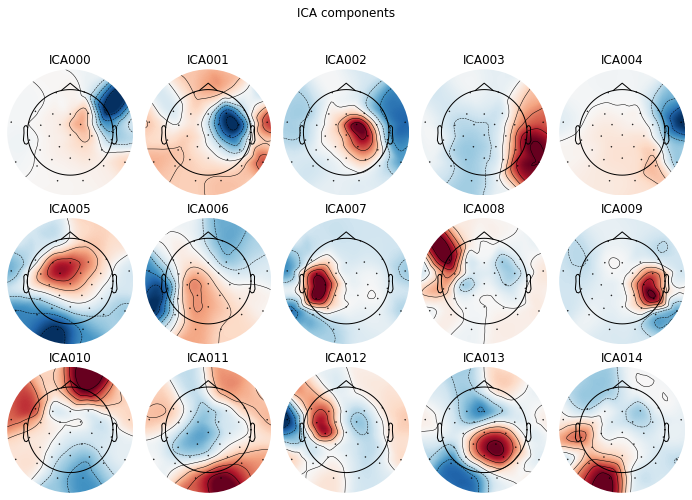

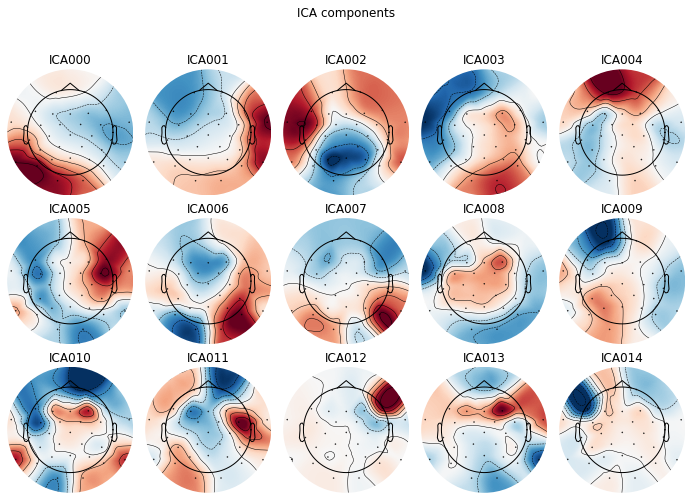

Which participant ICA do you want to use as a template for artifact rejection? Index begins at zero. (If you do not want to apply ICA on your data, do not enter nothing and press enter.)1
Which IC do you want to use as a template? Index begins at zero. (If you did not choosea participant number at first question,then do not enter nothing and press enter againto not apply ICA on your data)1


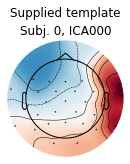

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


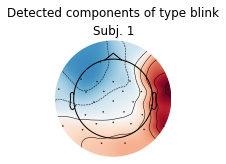

[{'blink': []}, {'blink': [1]}]
Transforming to ICA space (15 components)
Zeroing out 0 ICA components
Transforming to ICA space (15 components)
Zeroing out 1 ICA component


In [13]:
cleaned_epochs_ICA = prep.ICA_choice_comp(icas, [epo1, epo2])

For using PDC measure (Partial Coherence Connectivity), we should use the data that no ICA algorithm is applied on them.

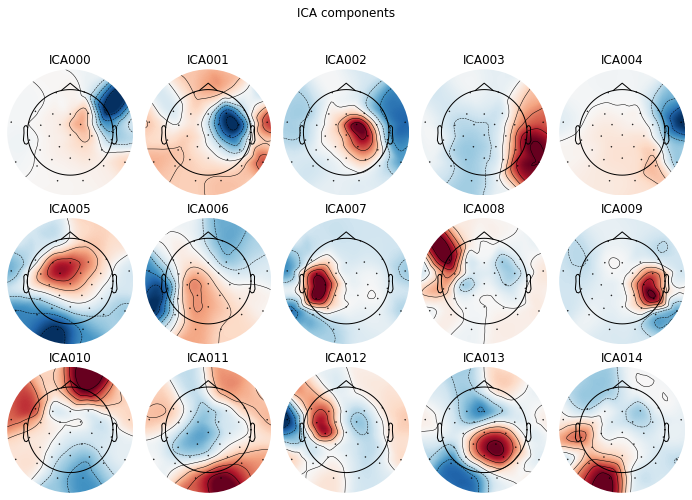

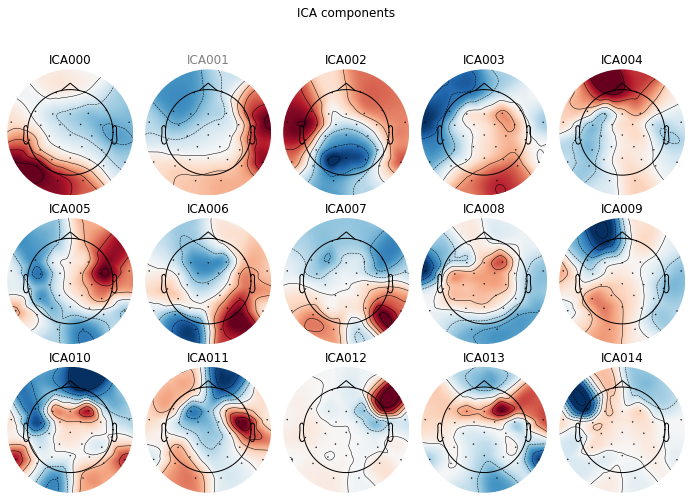

Which participant ICA do you want to use as a template for artifact rejection? Index begins at zero. (If you do not want to apply ICA on your data, do not enter nothing and press enter.)
Which IC do you want to use as a template? Index begins at zero. (If you did not choosea participant number at first question,then do not enter nothing and press enter againto not apply ICA on your data)


In [14]:
#without ICA -> computing PDC based on MVARICA approach
cleaned_epochs_no_ICA = prep.ICA_choice_comp(icas, [epo1, epo2])

### Autoreject
Applying local AutoReject for each participant rejecting bad epochs, rejecting or interpolating partially bad channels removing the same bad channels and epochs across participants plotting signal before and after (verbose=True)

Creating augmented epochs:  26%|██▌       | 8/31 [00:00<00:00, 74.81it/s]

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 31/31 [00:05<00:00,  5.92it/s]


Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 214.72it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs:  17%|█▋        | 6/36 [00:00<00:00, 56.83it/s]

Repairing epochs:  33%|███▎      | 12/36 [00:00<00:00, 54.48it/s]

Repairing epochs:  58%|█████▊    | 21/36 [00:00<00:00, 68.01it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 64.62it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:01,  8.87it/s]


Fold:  30%|███       | 3/10 [00:00<00:00, 10.58it/s]


Fold:  50%|█████     | 5/10 [00:00<00:00, 10.62it/s]


Fold:  70%|███████   | 7/10 [00:00<00:00, 10.65it/s]


Fold: 100%|██████████| 10/10 [00:00<00:00, 10.69it/s]

n_interp:  33%|███▎      | 1/3 [00:01<00:03,  1.59s/it]

Repairing epochs:   0%|          | 0/36 [00





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 31/31 [00:05<00:00,  5.97it/s]


Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 220.70it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs:  22%|██▏       | 8/36 [00:00<00:00, 70.45it/s]

Repairing epochs:  44%|████▍     | 16/36 [00:00<00:00, 69.92it/s]

Repairing epochs:  64%|██████▍   | 23/36 [00:00<00:00, 69.12it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 68.05it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:01,  7.91it/s]


Fold:  20%|██        | 2/10 [00:00<00:00,  9.02it/s]


Fold:  30%|███       | 3/10 [00:00<00:00,  9.24it/s]


Fold:  40%|████      | 4/10 [00:00<00:00,  9.45it/s]


Fold:  60%|██████    | 6/10 [00:00<00:00, 10.22it/s]


Fold:  80%|████████  | 8/10 [00:00<00:00, 10.76it/s]


Fold: 100%|██████████| 10/10 [00:00<00:00, 10





Estimated consensus=0.30 and n_interpolate=4
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20





Repairing epochs:   0%|          | 0/28 [00:00<?, ?it/s]

Repairing epochs:  25%|██▌       | 7/28 [00:00<00:00, 63.23it/s]

Repairing epochs:  61%|██████    | 17/28 [00:00<00:00, 83.45it/s]

Repairing epochs: 100%|██████████| 28/28 [00:00<00:00, 67.75it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20





Repairing epochs:   0%|          | 0/28 [00:00<?, ?it/s]

Repairing epochs:  29%|██▊       | 8/28 [00:00<00:00, 76.27it/s]

Repairing epochs:  57%|█████▋    | 16/28 [00:00<00:00, 70.45it/s]

Repairing epochs: 100%|██████████| 28/28 [00:00<00:00, 67.03it/s]


No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
22.22222222222222 percent of bad epochs


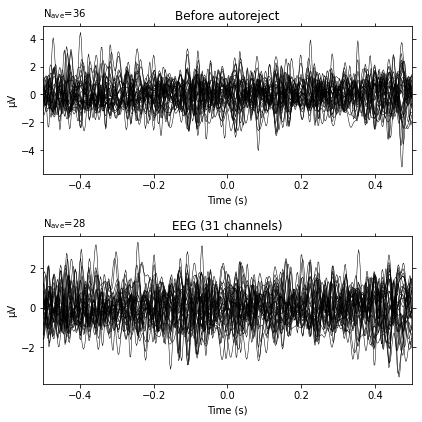

<Figure size 432x288 with 0 Axes>

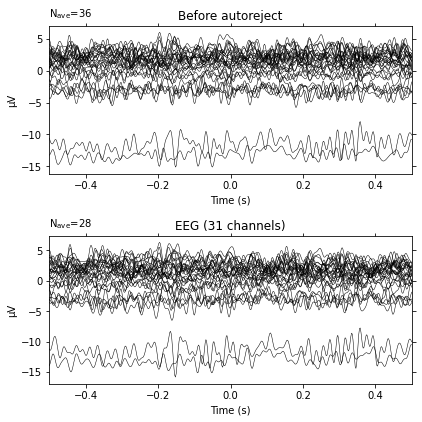

<Figure size 432x288 with 0 Axes>

In [15]:
#with ICA

cleaned_epochs_AR, dic_AR = prep.AR_local(cleaned_epochs_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)

Creating augmented epochs:  29%|██▉       | 9/31 [00:00<00:00, 81.09it/s]

Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 31/31 [00:05<00:00,  5.87it/s]


Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 215.20it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs:  19%|█▉        | 7/36 [00:00<00:00, 67.93it/s]

Repairing epochs:  39%|███▉      | 14/36 [00:00<00:00, 61.40it/s]

Repairing epochs:  67%|██████▋   | 24/36 [00:00<00:00, 75.82it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 68.58it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:01,  8.64it/s]


Fold:  20%|██        | 2/10 [00:00<00:00,  9.30it/s]


Fold:  40%|████      | 4/10 [00:00<00:00, 10.42it/s]


Fold:  60%|██████    | 6/10 [00:00<00:00, 10.85it/s]


Fold:  80%|████████  | 8/10 [00:00<00:00, 11.25it/s]


Fold: 100%|██████████| 10/10 [00:00<00:00, 10.85it/s]

n_interp:  33%|███▎      | 1/3 [00:01<00:03, 





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 31/31 [00:05<00:00,  5.99it/s]


Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 229.48it/s]

n_interp:   0%|          | 0/3 [00:00<?, ?it/s]

Repairing epochs:   0%|          | 0/36 [00:00<?, ?it/s]

Repairing epochs:  19%|█▉        | 7/36 [00:00<00:00, 65.33it/s]

Repairing epochs:  50%|█████     | 18/36 [00:00<00:00, 88.50it/s]

Repairing epochs:  75%|███████▌  | 27/36 [00:00<00:00, 75.46it/s]

Repairing epochs: 100%|██████████| 36/36 [00:00<00:00, 75.70it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:01,  7.96it/s]


Fold:  20%|██        | 2/10 [00:00<00:00,  8.89it/s]


Fold:  30%|███       | 3/10 [00:00<00:00,  9.27it/s]


Fold:  50%|█████     | 5/10 [00:00<00:00, 10.03it/s]


Fold:  60%|██████    | 6/10 [00:00<00:00,  9.89it/s]


Fold:  80%|████████  | 8/10 [00:00<00:00, 10.31it/s]


Fold: 100%|██████████| 10/10 [00:00<00:00, 10





Estimated consensus=0.20 and n_interpolate=1
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20




Repairing epochs:   0%|          | 0/28 [00:00<?, ?it/s]

Repairing epochs:  25%|██▌       | 7/28 [00:00<00:00, 63.18it/s]

Repairing epochs:  68%|██████▊   | 19/28 [00:00<00:00, 88.64it/s]

Repairing epochs: 100%|██████████| 28/28 [00:00<00:00, 71.80it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20





Repairing epochs:   0%|          | 0/28 [00:00<?, ?it/s]

Repairing epochs:  36%|███▌      | 10/28 [00:00<00:00, 95.19it/s]

Repairing epochs: 100%|██████████| 28/28 [00:00<00:00, 80.15it/s]


No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
22.22222222222222 percent of bad epochs


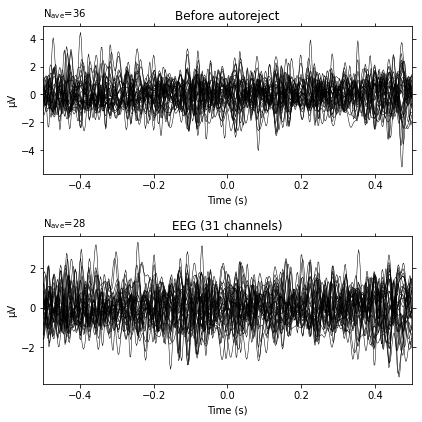

<Figure size 432x288 with 0 Axes>

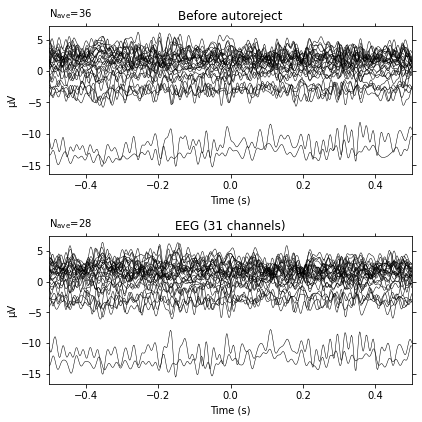

<Figure size 432x288 with 0 Axes>

In [16]:
#without ICA

no_ICA_cleaned_epochs_AR, no_ICA_dic_AR = prep.AR_local(cleaned_epochs_no_ICA,
                                          strategy="union",
                                          threshold=50.0,
                                          verbose=True
)


### Picking the preprocessed epochs for each participant

In [17]:
#with ICA
preproc_S1 = cleaned_epochs_AR[0]
preproc_S2 = cleaned_epochs_AR[1]

In [18]:
#without ICA
no_ICA_preproc_S1 = no_ICA_cleaned_epochs_AR[0]
no_ICA_preproc_S2 = no_ICA_cleaned_epochs_AR[1]

## Analysing data
### Welch Power Spectral Density
Here for ex, the frequency-band-of-interest is restricted to Alpha_Low, frequencies for which power spectral density is actually computed are returned in freq_list, and PSD values are averaged across epochs

In [19]:
#with ICA

psd1 = analyses.pow(preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
psd2 = analyses.pow(preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
data_psd = np.array([psd1.psd, psd2.psd])

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


In [20]:
#without ICA

no_ICA_psd1 = analyses.pow(no_ICA_preproc_S1, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_psd2 = analyses.pow(no_ICA_preproc_S2, fmin=7.5, fmax=11,
                    n_fft=1000, n_per_seg=1000, epochs_average=True)
no_ICA_data_psd = np.array([no_ICA_psd1.psd, no_ICA_psd2.psd])

Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


### Connectivity
Initializing data and storage

In [21]:
#with ICA
data_inter = np.array([preproc_S1, preproc_S2])
result_intra = []

In [22]:
#without ICA
no_ICA_data_inter = np.array([no_ICA_preproc_S1, no_ICA_preproc_S2])
no_ICA_result_intra = []
no_ICA_result_inter = []

Computing analytic signal per frequency band

In [23]:
#with ICA
complex_signal = analyses.compute_freq_bands(data_inter, sampling_rate,
                                             freq_bands)

/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning

In [24]:
#without ICA
no_ICA_complex_signal = analyses.compute_freq_bands(no_ICA_data_inter, sampling_rate,
                                             freq_bands)

/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  for participant in range(2)
/usr/local/lib/python3.7/dist-packages/hypyp/analyses.py:645: RuntimeWarning

Computing frequency- and time-frequency-domain connectivity, 'ccorr' for example

In [25]:
result = analyses.compute_sync(complex_signal, mode='ccorr')

Slicing results to get the Inter-brain part of the matrix

In [26]:
n_ch = len(epo1.info['ch_names'])
theta, alpha_low, alpha_high, beta, gamma = result[:, 0:n_ch, n_ch:2*n_ch]


Choosing Alpha_Low for futher analyses for example

In [27]:
values = alpha_low
values -= np.diag(np.diag(values))

Computing Cohens'D for further analyses for example

In [28]:
C = (values - np.mean(values[:])) / np.std(values[:])

Slicing results to get the Intra-brain part of the matrix

In [29]:
for i in [0, 1]:
    theta, alpha_low, alpha_high, beta, gamma = result[:, i:i+n_ch, i:i+n_ch]
    # choosing Alpha_Low for futher analyses for example
    values_intra = alpha_low
    values_intra -= np.diag(np.diag(values_intra))
    # computing Cohens'D for further analyses for example
    C_intra = (values_intra -
               np.mean(values_intra[:])) / np.std(values_intra[:])
    # can also sample CSD values directly for statistical analyses
    result_intra.append(C_intra)

Computing frequency- and time-frequency-domain connectivity measures obtained by MVARICA approach, based on MVAR models' coefficients. For instance: PDC measure, with MVAR model of order 2, extended infomax ICA method and checking the MVAR model stability.

In [30]:
mvar_result = analyses.compute_conn_mvar(no_ICA_complex_signal, 
                                         mvar_params={"mvar_order": 2, "fitting_method":"default", "delta": 0},
                                         ica_params={"method": "infomax_extended", "random_state": None},
                                         measure_params={"name": "pdc", "n_fft": 512}
                                         )

MVAR model is not stable: number of time samples may be too small


At least 7688 samples are required for fitting MVAR model


Do you want to merge the epochs? YES
MVAR model is stable
 Do you want to continue? YES
Computing Extended Infomax ICA
Computing Extended Infomax ICA
Computing Extended Infomax ICA
Computing Extended Infomax ICA
Computing Extended Infomax ICA


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Slicing results to get the Inter-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

In [31]:
for i in [0, 1]:
    mvar_result = mvar_result.squeeze()
    if i == 0 :
      mvar_theta, mvar_alpha_low, mvar_alpha_high, mvar_beta, mvar_gamma =  mvar_result[:, n_ch:n_ch*2, 0:n_ch, :]
    else:
      mvar_theta, mvar_alpha_low, mvar_alpha_high, mvar_beta, mvar_gamma =  mvar_result[:, 0:n_ch, n_ch:n_ch*2, :]
    # choosing Alpha_Low for futher analyses for example
    auxiliary = np.zeros((n_ch, n_ch), dtype=mvar_result.dtype)
    for j in range(0, n_ch):
      for k in range(0, n_ch):
        auxiliary[j, k] = np.amax(mvar_alpha_low[j,k])
    mvar_values_inter = auxiliary
    # computing Cohens'D for further analyses for example
    mvar_C_inter = (mvar_values_inter -
               np.mean(mvar_values_inter[:])) / np.std(mvar_values_inter[:])
    # can also sample CSD values directly for statistical analyses
    no_ICA_result_inter.append(mvar_C_inter)

Slicing results to get the Intra-brain of the connectivity matrix and assigning the maximum value in the frequency spectrum (mvar-based connectivity measures are calculated over a frequency range assigned by n_fft variable, here n_fft = 512)

In [32]:
for i in [0, 1]:
    mvar_result = mvar_result.squeeze()
    mvar_theta, mvar_alpha_low, mvar_alpha_high, mvar_beta, mvar_gamma =  mvar_result[:, i*n_ch:n_ch*(i+1), i*n_ch:n_ch*(i+1), :]
    # choosing Alpha_Low for futher analyses for example
    auxiliary = np.zeros((n_ch, n_ch), dtype=mvar_result.dtype)
    for j in range(0, n_ch):
      for k in range(0, n_ch):
        auxiliary[j, k] = np.amax(mvar_alpha_low[j, k])
    mvar_alpha_low = auxiliary
    mvar_values_intra = mvar_alpha_low
    mvar_values_intra -= np.diag(np.diag(mvar_values_intra))
    # computing Cohens'D for further analyses for example
    mvar_C_intra = (mvar_values_intra -
               np.mean(mvar_values_intra[:])) / np.std(mvar_values_intra[:])
    # can also sample CSD values directly for statistical analyses
    no_ICA_result_intra.append(mvar_C_intra)

## Statistical analyses
### Comparing PSD values to random signal
Parametric t test

####1/ MNE test without any correction
This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension


In [37]:
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)
X = np.array([psd1_mean, psd2_mean])
T_obs, p_values, H0 = mne.stats.permutation_t_test(X=X, n_permutations=5000,
                                                   tail=0, n_jobs=1)

Permuting 1 times (exact test)...


In [38]:
statsCondTuple = stats.statsCond(data=data_psd,
                                 epochs=preproc_S1,
                                 n_permutations=5000,
                                 alpha=0.05)

Permuting 1 times (exact test)...


####3/ Non-parametric cluster-based permutations¶
Creating matrix of a priori connectivity between channels across space and frequencies based on their position, in the Alpha_Low band for example

In [39]:
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


Creating two fake groups with twice the 'participant1' and twice the 'participant1'

In [40]:
data_group = [np.array([psd1.psd, psd1.psd]), np.array([psd2.psd, psd2.psd])]

statscondCluster = stats.statscondCluster(data=data_group,
                                          freqs_mean=psd1.freq_list,
                                          ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering


/usr/local/lib/python3.7/dist-packages/hypyp/stats.py:341: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_power=1, out_type='mask')
/usr/local/lib/python3.7/dist-packages/mne/stats/parametric.py:180: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Found 1 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/mne/stats/parametric.py:180: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Computing cluster p-values
Done.


###Comparing Intra-brain connectivity values between participants¶
With 3/ non-parametric cluster-based permutations creating matrix of a priori connectivity between channels across space and frequencies based on their position

In [41]:
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1, freqs_mean=np.arange(7.5, 11), draw=False)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [42]:
ch_con = con_matrixTuple.ch_con

Create again two fake groups with twice the 'participant1' and twice the 'participant2'

In Alpha_Low band for example (see above):

In [43]:
Alpha_Low = [np.array([result_intra[0], result_intra[0]]),
             np.array([result_intra[1], result_intra[1]])]

statscondCluster_intra = stats.statscondCluster(data=Alpha_Low,
                                                freqs_mean=np.arange(7.5, 11),
                                                ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
                                                tail=0,
                                                n_permutations=5000,
                                                alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering


/usr/local/lib/python3.7/dist-packages/hypyp/stats.py:341: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_power=1, out_type='mask')
/usr/local/lib/python3.7/dist-packages/mne/stats/parametric.py:180: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Found 1 clusters
Permuting 4999 times...


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

/usr/local/lib/python3.7/dist-packages/mne/stats/parametric.py:180: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


Computing cluster p-values
Done.


###Comparing Inter-brain connectivity values to random signal¶
No a priori connectivity between channels is considered between the two participants

In Alpha_Low band for example (see above), create another time two fake groups with twice the 'participant1' and twice the 'participant2'

In [44]:
data = [np.array([values, values]), np.array([result_intra[0], result_intra[0]])]

statscondCluster = stats.statscondCluster(data=data,
                                          freqs_mean=np.arange(7.5, 11),
                                          ch_con_freq=None,
                                          tail=0,
                                          n_permutations=5000,
                                          alpha=0.05)

Using a threshold of 18.512821
stat_fun(H1): min=inf max=inf
Running initial clustering
Found 1 clusters
Permuting 4999 times...


/usr/local/lib/python3.7/dist-packages/hypyp/stats.py:341: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  t_power=1, out_type='mask')
/usr/local/lib/python3.7/dist-packages/mne/stats/parametric.py:180: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


  0%|          |  : 0/4999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


##Visualization
###Visualization of T values for sensors
for 1/ T_obs_plot = T_obs

for 2/ statsCondTuple.T_obs

for 3/ statscondCluster.F_obs_plot

In [45]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs, epochs=preproc_S1)

###Vizualize T values for significant sensors only

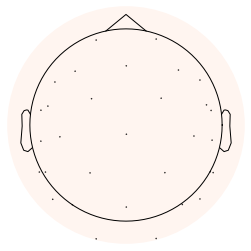

In [46]:
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot, epochs=preproc_S1)

###Visulization of inter-brain links projected
on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [47]:
epo1.info['bads'] = ['F8', 'Fp2', 'Cz', 'O2']
epo2.info['bads'] = ['F7', 'O1']

###Visualisation of brain connectivity in 2D and 3D
Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, it is calculated specifically for the dyad, and therefore does not allow comparability between different dyads.

####Visualization of inter-brain connectivity in 2D

Inter-brain Hilbert-based connectivity

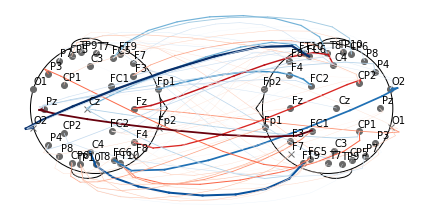

In [48]:
viz.viz_2D_topomap_inter(epo1, epo2, C, threshold='auto', steps=10, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

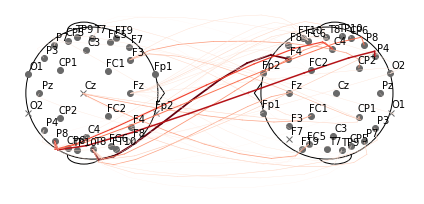

In [49]:
viz.viz_2D_topomap_inter(epo1, epo2, no_ICA_result_inter[0], threshold='auto', steps=10, lab=True)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

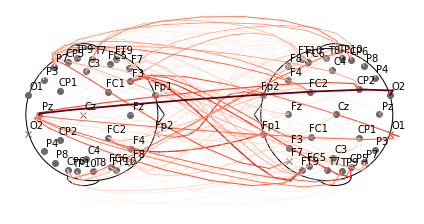

In [50]:
viz.viz_2D_topomap_inter(epo1, epo2, no_ICA_result_inter[1], threshold='auto', steps=10, lab=True)

####Visualization of inter-brain connectivity in 3D

Inter-brain Hilbert-based connectivity


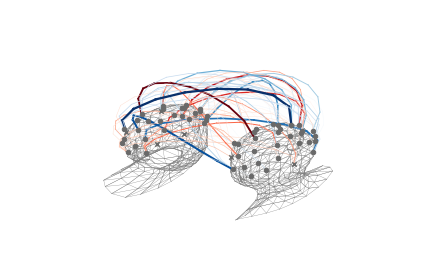

In [51]:
viz.viz_3D_inter(epo1, epo2, C, threshold='auto', steps=10, lab=False)

Inter-brain VAR-based connectivity (information flow from participant 1 to participant 2)

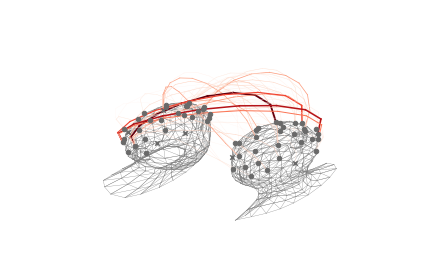

In [52]:
viz.viz_3D_inter(epo1, epo2, no_ICA_result_inter[0], threshold='auto', steps=10, lab=False)

Inter-brain VAR-based connectivity (information flow from participant 2 to participant 1)

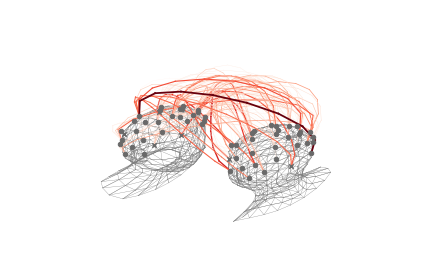

In [53]:
viz.viz_3D_inter(epo1, epo2, no_ICA_result_inter[1], threshold='auto', steps=10, lab=False)

####Visualization of intra-brain connectivity in 2D

Intra-brain Hilbert-based connectivity

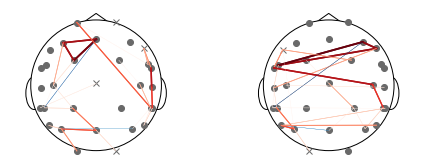

In [54]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

Intra-brain VAR-based connectivity

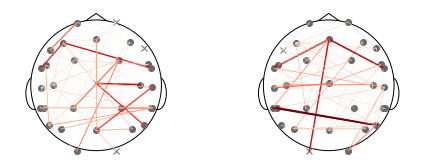

In [55]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= no_ICA_result_intra[0],
                         C2= no_ICA_result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

####Visualization of intra-brain connectivity in 3D

Intra-brain Hilbert-based connectivity

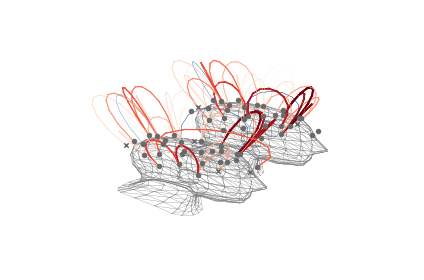

In [56]:
viz.viz_3D_intra(epo1, epo2,
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False)

Intra-brain VAR-based connectivity

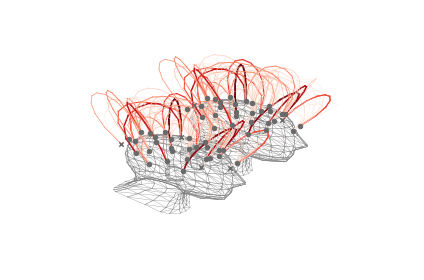

In [57]:
viz.viz_3D_intra(epo1, epo2,
                 C1= no_ICA_result_intra[0],
                 C2= no_ICA_result_intra[0],
                 threshold='auto',
                 steps=10,
                 lab=False)